In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import collections
import math
import random

#### Hyperparameters

In [3]:
embedding_size = 128 # aka dimensions
iiter = 200 # Number of epochs
vocabulary_size = 77 # Number of nodes
batch_size = 10 # Number of pairs (target, context) in each example
num_sampled = 64 # Number of negative examples to sample for NCF

##### A fake test dataset of Walks, as generated by node2vec

In [4]:
walks = [[5, 0, 3, 11, 49, 55, 48, 11, 43, 27],
 [16, 18, 17, 19, 20, 23, 24, 23, 17, 19],
 [0, 2, 3, 0, 1, 0, 2, 3, 11, 64],
 [67, 57, 65, 60, 64, 60, 66, 63, 48, 61],
 [8, 0, 5, 0, 7, 0, 9, 0, 4, 0],
 [37, 34, 11, 69, 25, 41, 69, 25, 11, 71],
 [34, 29, 35, 29, 23, 17, 21, 18, 20, 23],
 [20, 21, 23, 12, 23, 12, 23, 30, 31, 30],
 [69, 41, 25, 69, 11, 0, 9, 0, 8, 0],
 [46, 47, 48, 65, 76, 66, 61, 58, 59, 62]]

#### Our function to generate skipgram training examples
Inspired from `generate_batch` from https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/word2vec/word2vec_basic.py

In [5]:
def generate_batch(walks, batch_size, num_skips, skip_window):
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    for walk in walks:
        for data_index in range(0, len(walk), span):
            batch = np.ndarray(shape=(batch_size), dtype=np.int32)
            labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
            buffer = walk[data_index:data_index + span]
            for i in range(batch_size // num_skips):
                context_words = [w for w in range(span) if w != skip_window]
                words_to_use = random.sample(context_words, num_skips)
                for j, context_word in enumerate(words_to_use):
                    batch[i * num_skips + j] = buffer[skip_window]
                    labels[i * num_skips + j, 0] = buffer[context_word]
            yield batch, labels


#### Definition of the TF graph

Also inspired from https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/word2vec/word2vec_basic.py

In [6]:
embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], 0, 1.0),
    name='embeddings'
)

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
nce_weights = tf.Variable(
  tf.truncated_normal([vocabulary_size, embedding_size],
                      stddev=1.0 / math.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))


In [8]:
train_inputs = tf.placeholder(tf.int32, shape=[batch_size], name='input')
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1], name='labels')
embed = tf.nn.embedding_lookup(embeddings, train_inputs)


In [9]:
loss = tf.reduce_mean(
    tf.nn.nce_loss(weights=nce_weights,
                     biases=nce_biases,
                     labels=train_labels,
                     inputs=embed,
                     num_sampled=num_sampled,
                     num_classes=vocabulary_size))


## Changing loss for non-negative embeddings

We add a (Lagrange) multiplier to the loss function, to _encourage_ it to avoid negative embeddings.

In [10]:
MULTIPLIER = 1

cost_of_negatives = tf.nn.softsign(tf.reduce_sum(-tf.minimum(0., embeddings)))
loss_with_constraint = loss + MULTIPLIER * cost_of_negatives

In [11]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(
    loss_with_constraint
)

Instructions for updating:
Use tf.cast instead.


### Example execution

In [12]:
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    for epoch in range(iiter):
        for inputs, labels in generate_batch(walks, batch_size=batch_size,
                                             num_skips=2, skip_window=2):
            feed_dict = {train_inputs: inputs, train_labels: labels}
            _, cur_loss, cur_loss_wc = session.run([
                optimizer, loss, loss_with_constraint
            ], feed_dict=feed_dict)
#             print(cur_loss, cur_loss_wc - cur_loss)
    results = embeddings.eval()


Resulting embeddings:

In [13]:
results.shape

(77, 128)

In [14]:
results

array([[0.39323243, 0.6211766 , 0.4020989 , ..., 0.7087907 , 0.00874951,
        0.04800582],
       [0.9588983 , 0.05198693, 0.28070462, ..., 0.44969094, 0.5727258 ,
        0.7706909 ],
       [0.56881046, 0.12440503, 0.48554206, ..., 0.6390735 , 0.4680568 ,
        0.9839276 ],
       ...,
       [0.83965755, 0.7913872 , 0.02407944, ..., 0.7929523 , 0.23470879,
        0.5104629 ],
       [0.37165976, 0.2372061 , 0.7314333 , ..., 0.33663046, 0.24231493,
        0.7060344 ],
       [0.36829138, 0.31573498, 0.7350762 , ..., 0.8012526 , 0.3398913 ,
        0.8343011 ]], dtype=float32)

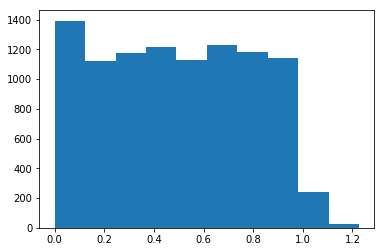

In [15]:
_ = plt.hist(results.flatten())